# Introduction to Data Science – Homework 8
*COMP 5360 / MATH 4100, University of Utah, http://datasciencecourse.net/*

Due: Friday, April 12 2024, 11:59pm.

In this homework, you will use clustering, principal component analysis, regular expressions, and natural language processing. 

## Your Data
First Name:Logan
<br>
Last Name: Correa
<br>
E-mail: u1094034@umail.utah.edu
<br>
UID: u1094034
<br>

In [104]:
# imports and setup 

import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, AgglomerativeClustering

from sklearn import tree, svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.cluster import DBSCAN

from sklearn.decomposition import PCA 

import nltk
from nltk.corpus import stopwords

import re

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('ggplot')

## Part 1: Analyze US Fast Food data

We'll analyze a dataset describing prevalence of some fast food restaurants by US State. Theses are subsetted/cleaned from the [Kaggle dataset by Rishi Darmala](https://www.kaggle.com/datasets/rishidamarla/fast-food-restaurants-in-america) and presented as number of each restaurant per million residents. 

Our goal will be to use unsupervised methods to understand how prevalence of these restaurants differ between states. 

### Task 1.1 Import the data and perform some preliminary exploratory analysis. 
Use the *read_csv* pandas function to import the data as a dataframe. (Note - Index of this dataframe should be the names of the state)

Plot a scatterplot matrix of the data. 
- Explore basic statistics of the data. 
- Describe how the variables are correlated. 

In [105]:
# read csv
food = pd.read_csv('FastFoodPerMillion.csv')

# set index
food.set_index('State', inplace=True)

display(food.head())

# descriptive statistics
food.describe()


,Arby's,Burger King,Domino's Pizza,KFC,McDonalds,Subway,Taco Bell,Wendy's
State,,,,,,,,
Alaska,4.29,0.00,2.86,0.00,4.29,0.00,0.00,1.43
Alabama,5.00,6.00,0.20,1.80,8.40,0.80,6.20,2.60
Arkansas,3.33,1.67,1.67,2.67,9.33,3.00,4.67,3.67
Arizona,0.97,2.22,2.08,1.53,4.72,1.39,2.22,1.67
California,0.08,1.47,0.41,0.61,3.39,0.99,1.77,0.66


,Arby's,Burger King,Domino's Pizza,KFC,McDonalds,Subway,Taco Bell,Wendy's
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000
mean,2.378000,3.989800,2.486600,1.571200,7.816200,2.206200,3.106000,2.67580
std,2.128369,1.978454,2.891761,0.905986,4.765441,2.360993,2.052185,1.74987
min,0.000000,0.000000,0.000000,0.000000,1.330000,0.000000,0.000000,0.00000
25%,0.695000,2.650000,0.665000,0.837500,4.752500,0.802500,1.782500,1.43000
50%,1.730000,3.965000,1.495000,1.490000,6.455000,1.450000,2.465000,2.48000
75%,3.660000,5.127500,2.890000,2.217500,9.302500,2.890000,4.267500,3.50250
max,8.890000,11.110000,12.220000,3.570000,28.330000,11.670000,8.330000,8.00000


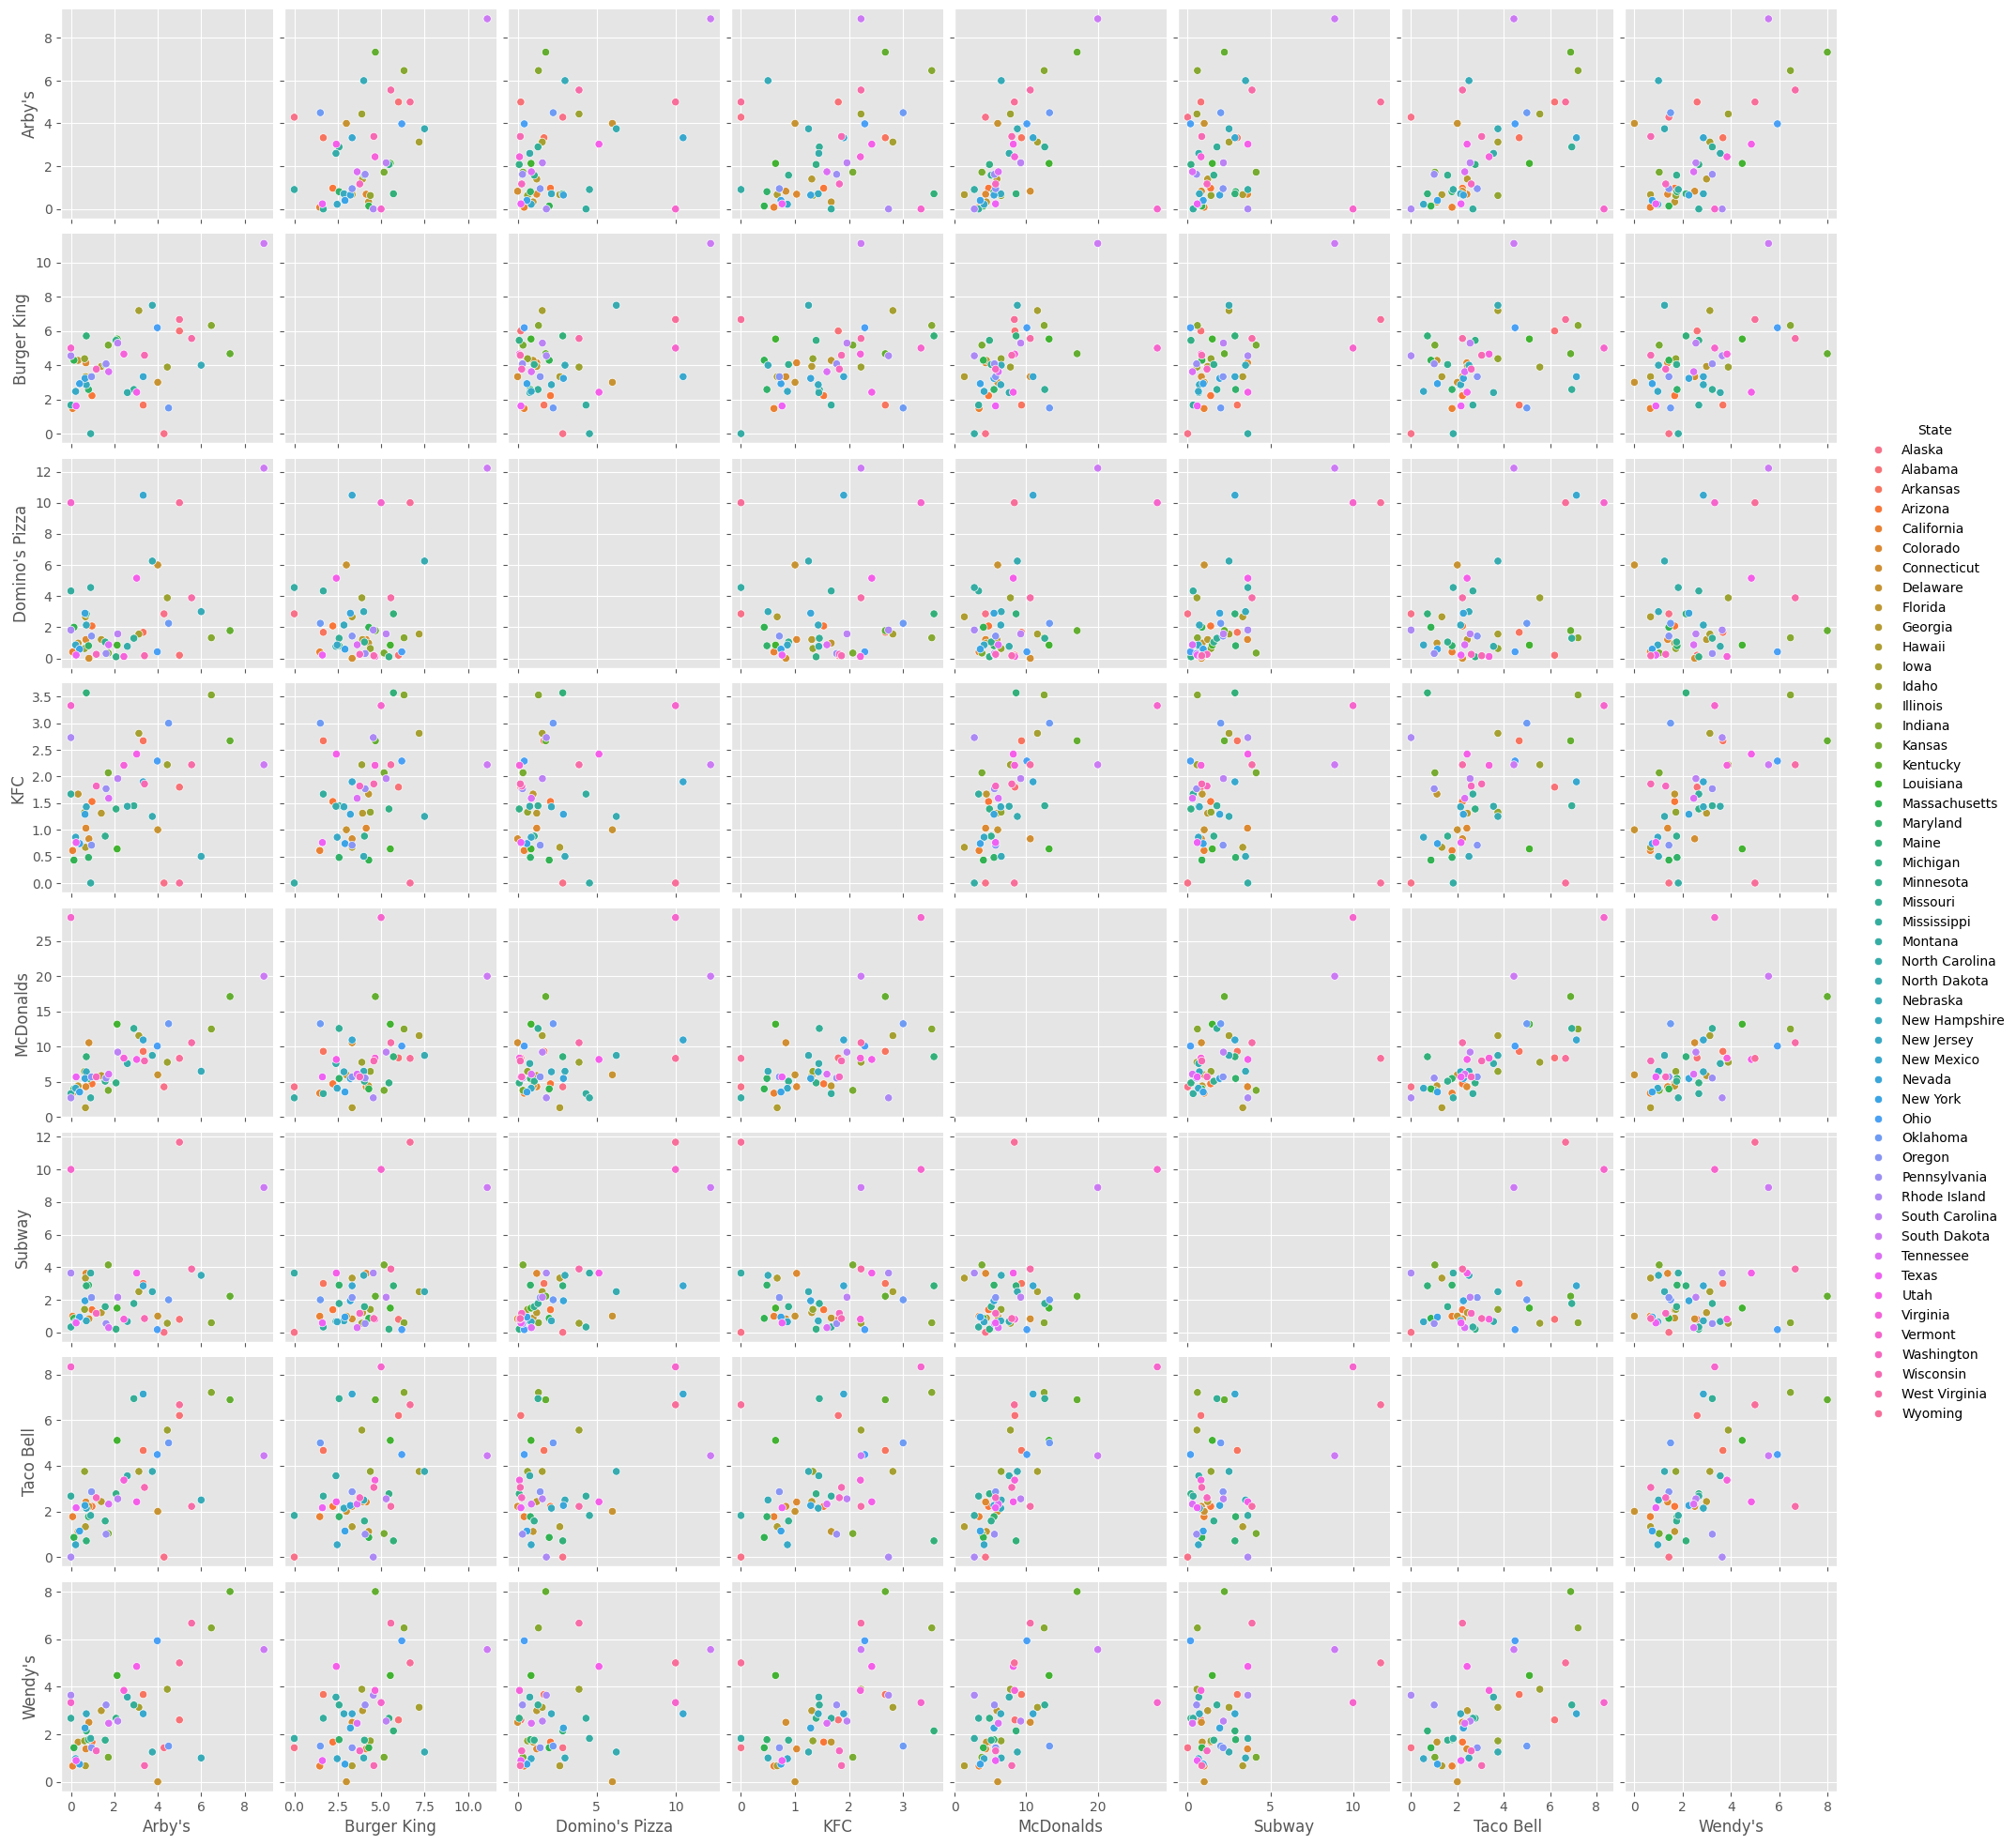

In [106]:
# scatter plot matrix
pairplot = sns.pairplot(food.assign(State=food.index), hue='State')


Text(0.5, 1.0, 'Correlation Matrix')

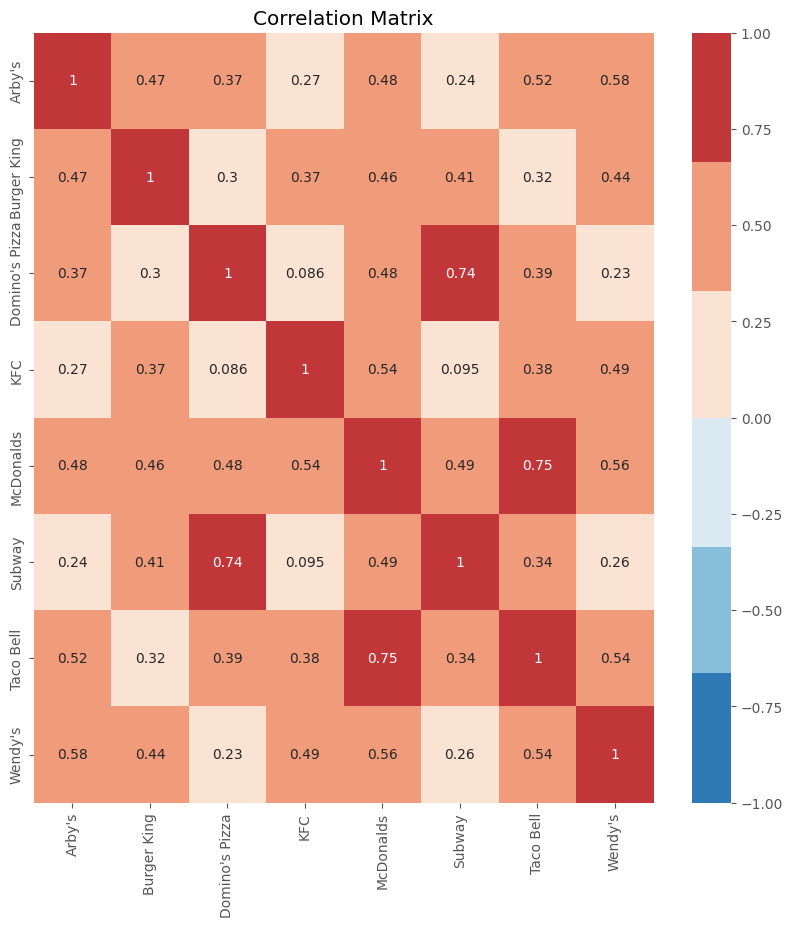

In [107]:
# correlation matrix
palette = sns.color_palette("RdBu_r")
sns.heatmap(food.corr(), annot=True, cmap=palette, center=0, vmin=-1, vmax=1)
plt.title('Correlation Matrix')

**Your description:**  
McDonald's leads with the highest average measure at 7.8162, indicating it potentially outperforms the others in this metric, perhaps sales or customer visits. KFC, on the other hand, has the lowest average of 1.5712. Dominos and Subway are highly correlated (0.74), as are McDonalds and Taco bell (0.75). There are no negative correlations.

### Task 1.2 - Cluster Heat Map

Generate a [cluster heat map](https://seaborn.pydata.org/generated/seaborn.clustermap.html) with a dendrogram using seaborn (see lecture). Be sure to standardize the dataset using the `standard_scale=1` parameter.

- How would you interpret this cluster map? 
- Describe any patterns you see.
- Is there anything in this data that surprises you? Do you trust it?

Text(0.5, 1.0, 'Cluster Heat Map')

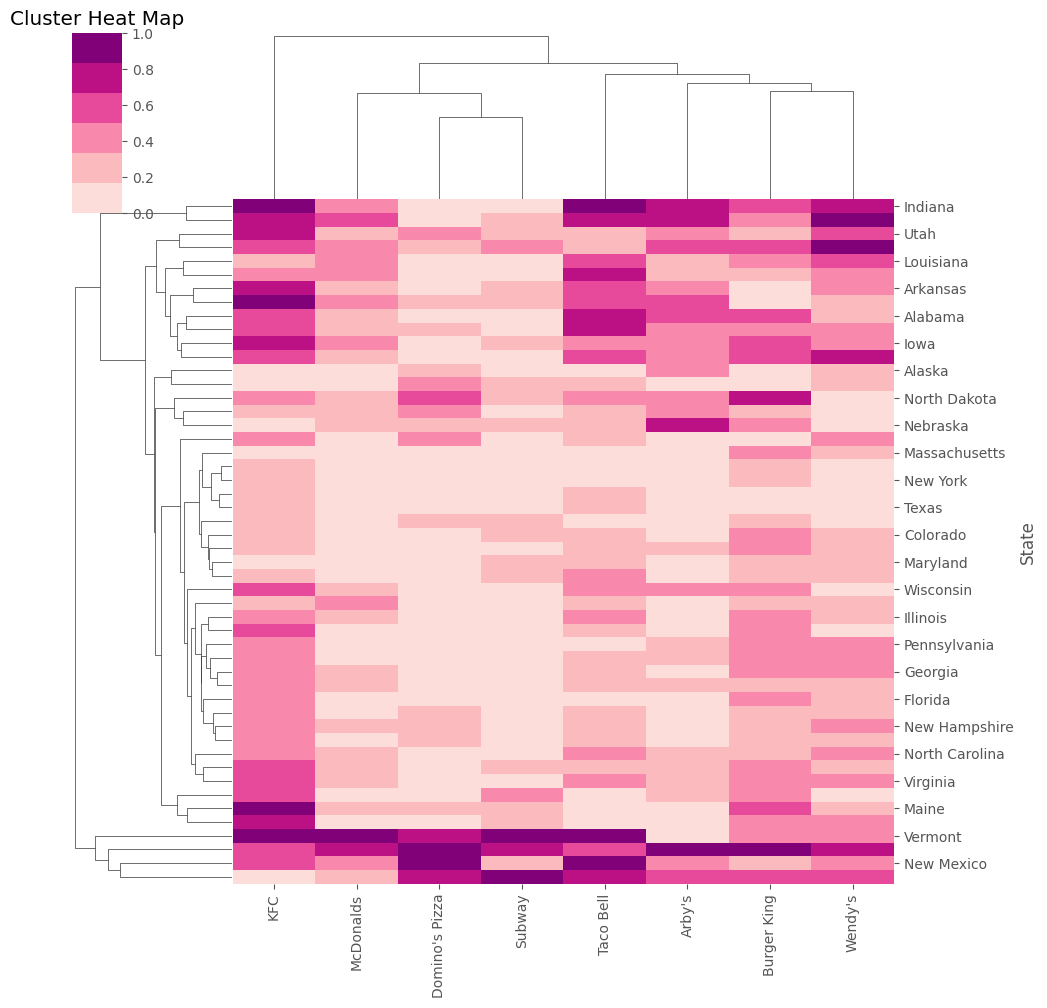

In [108]:
# cluster heat map
palette2 = sns.color_palette("RdPu")

sns.clustermap(food, cmap=palette2, standard_scale=1)
plt.title('Cluster Heat Map')


**Your Interpretation**:  Indiana, Utah, and Louisiana have similar preferences for fast food restaurants, as do Vermont and and New Mexico. KFC is an outgroup when compared to the rest of the restaurants.

### Task 1.3 Visualize the data using PCA

Complete the following steps:
1. Scale the dataset using the *scale* function of the sklearn.preprocessing library. 
+ Calculate the principal components of the dataset. 
+  Store the principal components in a pandas dataframe. (Note - Index of this dataframe should be the names of the state) 
+ Plot a scatterplot of PC1 and PC2. Using the matplotlib function *annotate*, use the state names as markers (instead of dots). From this scatterplot, can you tell approximately how many clusters our dataset shall have?
+ Print the explained variance ratio of the PCA. Plot the explained variance ratio of the PCA. After observing the explained variance ratio, how many dimensions would you reduce your data to? Why?

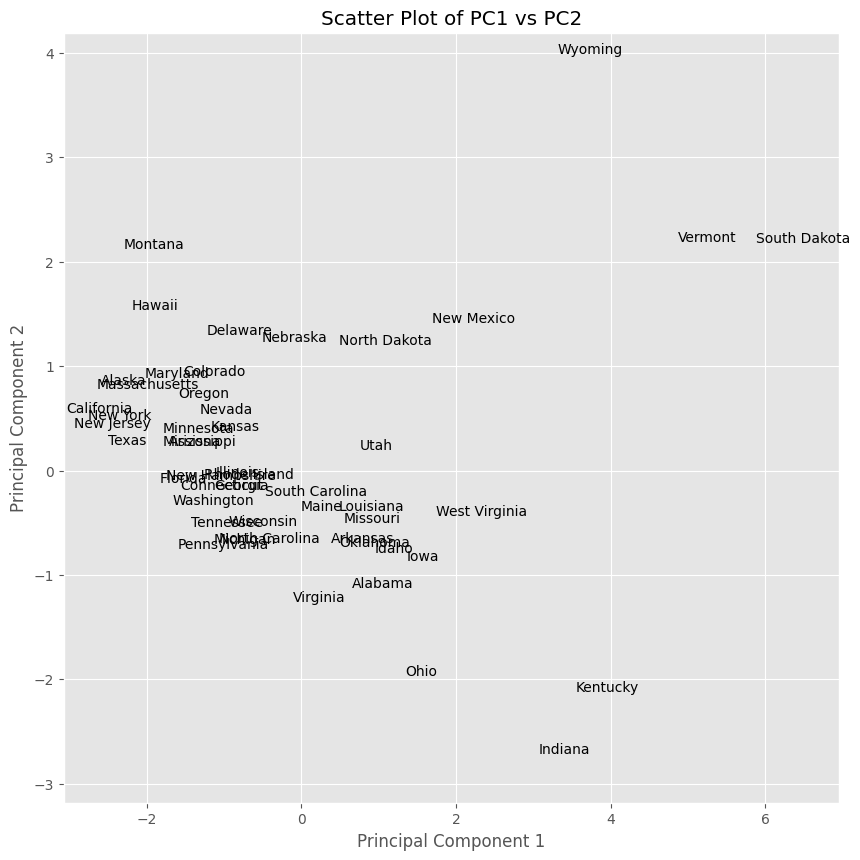

In [109]:
# scale data
food_scaled = scale(food)

# PCA
pca = PCA()
food_pca = pca.fit_transform(food_scaled)

# principal components dataframe
pca_df = pd.DataFrame(food_pca, columns=[f'PC{i+1}' for i in range(food_pca.shape[1])], index=food.index)

# scatter plot using state names as markers instead of dots
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha = 0)

for state in pca_df.index:
    plt.annotate(state, (pca_df.loc[state, 'PC1'], pca_df.loc[state, 'PC2']),
                 textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of PC1 vs PC2')
plt.grid(True)
plt.show()


Explained variance ratio: [0.49418903 0.16775439 0.09411434 0.09110439 0.05465528 0.04864843
 0.02604773 0.0234864 ]
Cumulative Explained Variance: [0.49418903 0.66194343 0.75605776 0.84716215 0.90181743 0.95046587
 0.9765136  1.        ]


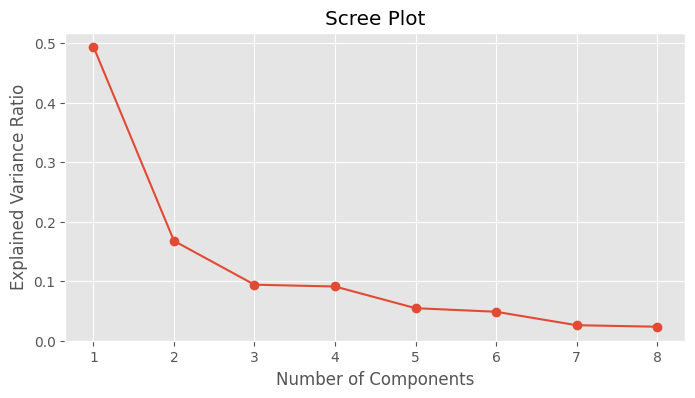

In [110]:
# Print the explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance)

# Print the cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
print("Cumulative Explained Variance:", cumulative_explained_variance)

# Plotting the explained variance ratio
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-')
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance) + 1))  # Ensure x-ticks for each component
plt.grid(True)
plt.show()

**Your description:** Based on the PCA scatterplot, there appears to be one main cluster with a smaller cluster in the top right corner of the graph. Based on the explained variance ratio, I would use 3 PCA components. This allows us to explain 75% of the variance within the data.


### Task 1.4 k-means cluster analysis

1. Using k-means, cluster the states into two clusters. **Use the scaled dataset**. Which states belong to which clusters?
2. Vary k (between 2 and 20) and check if there could be a better value for k. If yes, what is that value? Also, describe how did you find that value?
3. Use the principal components to plot the clustering corresponding to the k you chose in the previous question. Again label each point using the state name and this time color the states according to the clustering.


In [111]:
# kmeans clustering
kmeans = KMeans(n_clusters=2, n_init=10)
clusters = kmeans.fit_predict(food_scaled)

# Add the cluster labels to the PCA dataframe
cluster_df = pca_df.copy()
cluster_df['Cluster'] = clusters

# Iterate over each cluster and print the states in it
for cluster in cluster_df['Cluster'].unique():
    print(f"Cluster {cluster}:")
    states = cluster_df[cluster_df['Cluster'] == cluster].index.tolist()
    print(states)

Cluster 1:
['Alaska', 'Arizona', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Illinois', 'Kansas', 'Massachusetts', 'Maryland', 'Maine', 'Michigan', 'Minnesota', 'Mississippi', 'Montana', 'North Carolina', 'Nebraska', 'New Hampshire', 'New Jersey', 'Nevada', 'New York', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'Tennessee', 'Texas', 'Virginia', 'Washington', 'Wisconsin']
Cluster 0:
['Alabama', 'Arkansas', 'Iowa', 'Idaho', 'Indiana', 'Kentucky', 'Louisiana', 'Missouri', 'North Dakota', 'New Mexico', 'Ohio', 'Oklahoma', 'South Dakota', 'Utah', 'Vermont', 'West Virginia', 'Wyoming']


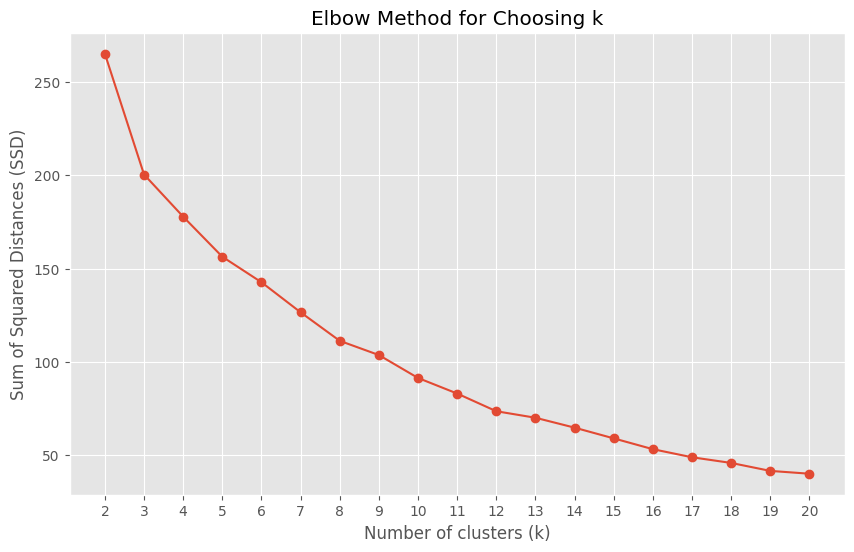

In [112]:
# evaluate kmean clustering using elbow method
# Range of k values
k_values = range(2, 21)
ssd = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(food_scaled)
    ssd.append(kmeans.inertia_)

# Plot the SSD for each k
plt.figure(figsize=(10, 6))
plt.plot(k_values, ssd, marker='o')
plt.title('Elbow Method for Choosing k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Distances (SSD)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

Text(0, 0.5, 'Principal Component 2')

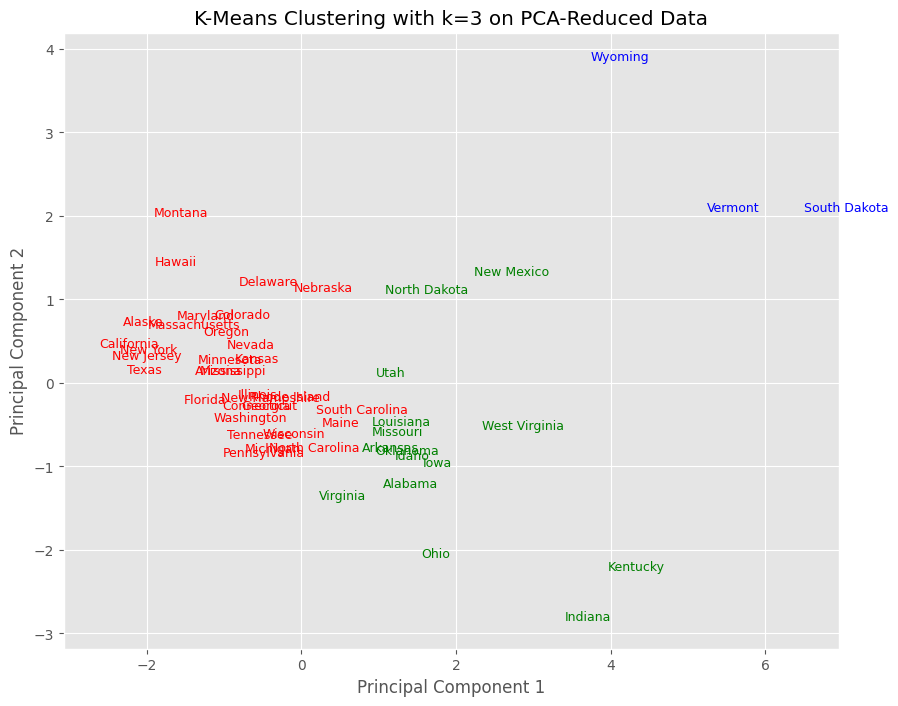

In [113]:
# kmeans clustering
kmeans2 = KMeans(n_clusters=3, n_init=10)
kclusters2 = kmeans2.fit_predict(food_scaled)

kcluster_df2 = pca_df.copy()

# Add the cluster labels to the PCA dataframe
kcluster_df2['Cluster'] = kclusters2

# Define a color palette for the clusters
colors = {0: 'red', 1: 'blue', 2: 'green'}

# Plotting the clusters
plt.figure(figsize=(10, 8))
plt.scatter(kcluster_df2['PC1'], kcluster_df2['PC2'], c=[colors[label] for label in kcluster_df2['Cluster']], alpha = 0)

# Annotate the plot with the state names, coloring each name according to its cluster
for i, txt in enumerate(kcluster_df2.index):
    plt.annotate(txt,
                 (kcluster_df2['PC1'].iloc[i], kcluster_df2['PC2'].iloc[i]),
                 color=colors[kcluster_df2['Cluster'].iloc[i]],
                 fontsize=9)

# Define the plot labels and title
plt.title('K-Means Clustering with k=3 on PCA-Reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

**Interpretation for best K:** Based on the elbow graph, I would chose k=3 for the number of clusters since that is where the line starts to dramatically slope towards zero.

**Interpretation for PCA and K-Means**: Using the K-Means method in conjunction with PCA we can see 3 clear clusters.

### Task 1.5 Hierarchical cluster analysis

1.  Using hierarchical clustering with complete linkage and Euclidean distance, cluster the states into the number of clusters you determined for k-means. Which states belong to which clusters? 
2. Visualize your cluster results on top of the first two principle components, as before.
3. Do you get similar results as for k-means? Can you see trends between the states?

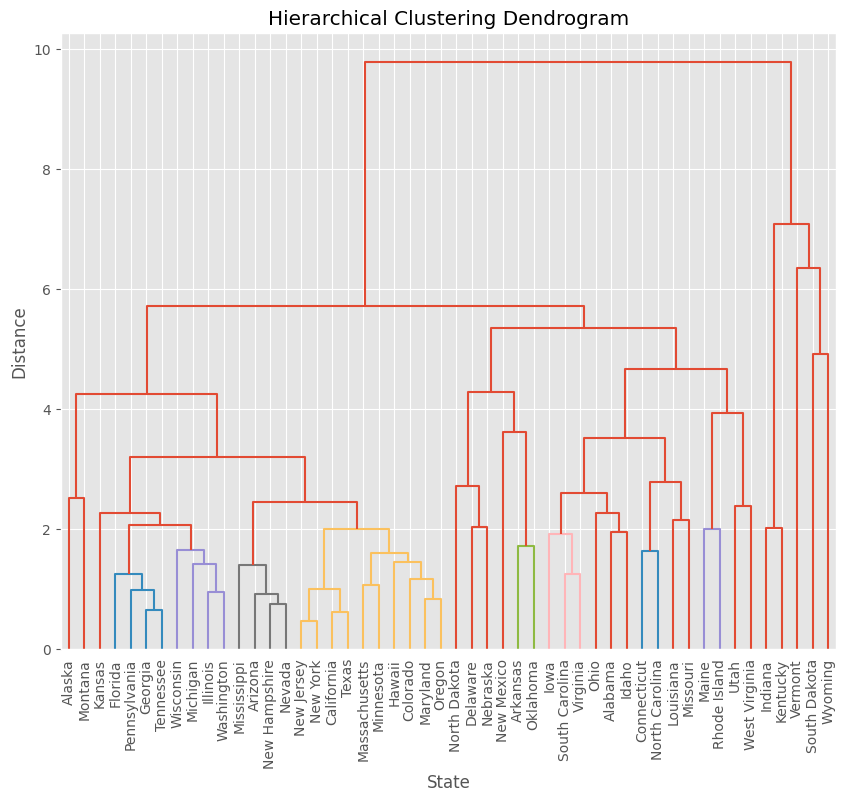

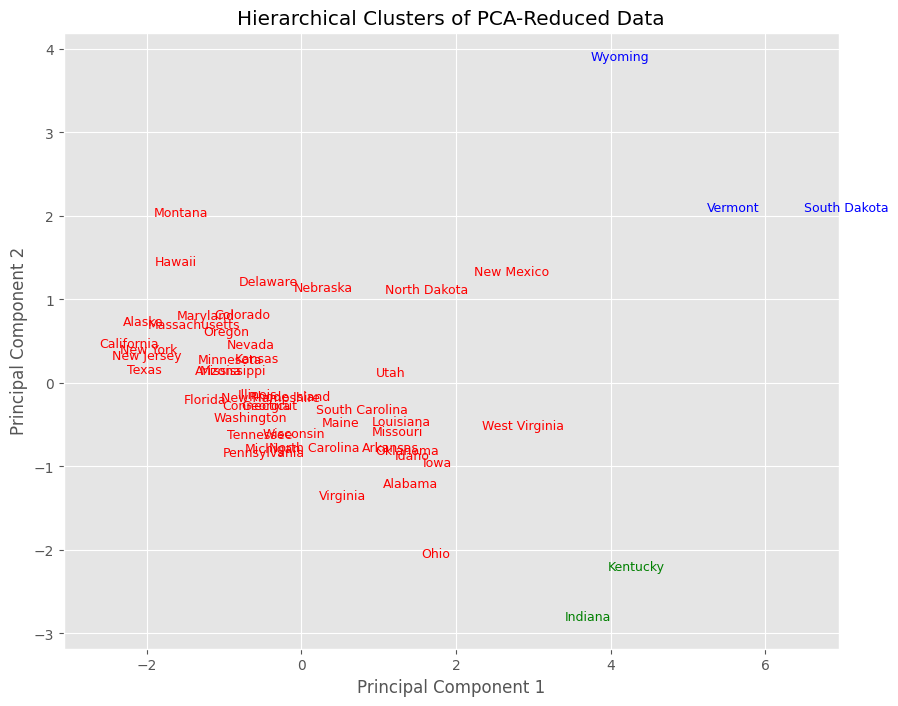

In [140]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy 
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_blobs

# Perform hierarchical clustering
Z = linkage(food_scaled, method='complete', metric='euclidean')

# Extract cluster labels
y_pred = hierarchy.fcluster(Z, t=3, criterion='maxclust')

# Append cluster information
hcluster_df = pca_df.copy()
hcluster_df['Cluster'] = y_pred  

# Plot the dendrogram
plt.figure(figsize=(10, 8))
dendrogram(Z, labels=food.index, leaf_rotation=90, leaf_font_size=10, color_threshold=2)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('State')
plt.ylabel('Distance')
plt.show()

# Define a color palette for the clusters
colors = {1: 'red', 2: 'green', 3: 'blue'}

# Plotting the clusters
plt.figure(figsize=(10, 8))
plt.scatter(hcluster_df['PC1'], hcluster_df['PC2'], c=[colors[label] for label in hcluster_df['Cluster']], alpha = 0)

# Annotate the plot with the state names, coloring each name according to its cluster
for i, txt in enumerate(hcluster_df.index):
    plt.annotate(txt,
                 (hcluster_df['PC1'].iloc[i], hcluster_df['PC2'].iloc[i]),
                 color=colors[hcluster_df['Cluster'].iloc[i]],
                 fontsize=9)

plt.title('Hierarchical Clusters of PCA-Reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

**Interpretation:** The hierarchical clustering had similar clusters to k-means but assigned more states from the second to the first cluster. The states in the third cluster remained the same between both models.

### Task 1.6 DBSCAN

1.  Using DBSCAN and experiment with different values for $\epsilon$ and min samples. Which states belong to which clusters? 
2. Visualize your cluster results on top of the first two principle components, as before.
3. Do you get similar results as before? Is DBSCAN stable or very sensitive to changes in epsilon for this dataset?

Estimated number of clusters: 2
Estimated number of noise points: 33
Homogeneity: 0.211
Completeness: 1.000
V-measure: 0.349


C:\Users\logan\AppData\Local\Temp\ipykernel_13632\3001867431.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color=colors.get(dbcluster_df['Cluster'][i], 'gray'),


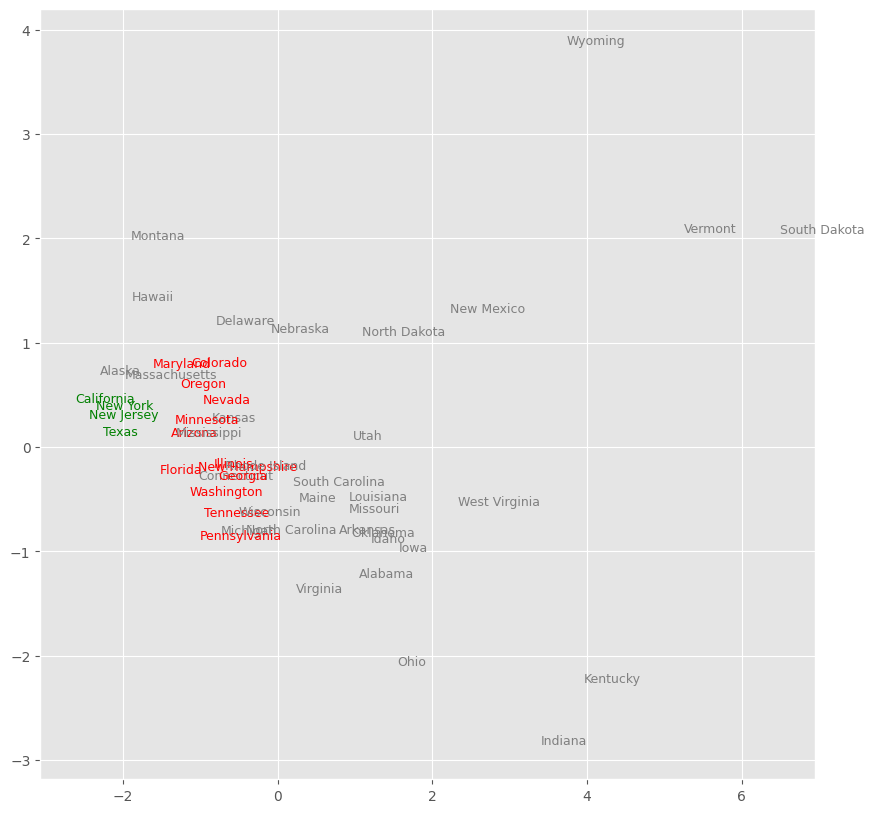

In [159]:

db_model = DBSCAN(eps=1.0, min_samples=2)
db_model.fit(food_scaled)
y_pred = db_model.fit_predict(food_scaled)

dbcluster_df = pca_df.copy()
dbcluster_df['Cluster'] = y_pred

# plot clusters
colors = {0: 'red', 1: 'green', 2: 'blue', -1: 'gray'} 
plt.scatter(dbcluster_df['PC1'], dbcluster_df['PC2'], c=[colors.get(label, 'gray') for label in dbcluster_df['Cluster']], alpha = 0)

# Annotate the plot with the state names, coloring each name according to its cluster
for i, txt in enumerate(dbcluster_df.index):
    plt.annotate(txt,
                 (dbcluster_df['PC1'].iloc[i], dbcluster_df['PC2'].iloc[i]),
                 color=colors.get(dbcluster_df['Cluster'][i], 'gray'),
                 fontsize=9)
    
labels = db_model.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print('Homogeneity: %0.3f' % metrics.homogeneity_score(food.index, labels))
print('Completeness: %0.3f' % metrics.completeness_score(food.index, labels))
print('V-measure: %0.3f' % metrics.v_measure_score(food.index, labels))




**Your Interpretation**: DBscan had much different clusters than k-means and hierchacal clustering and it is very sensitive to changes in epsilon. Many states were removed as noise.

# 2. Regular Expressions 

Write regular expressions for the following examples that matches the data of the given format and any other reasonable variations thereof. E.g., your regex shouldn't be specific to one URL or one phone number, but should work for all examples of the same format.

**Task 2.1.** Writes a regular expression that extracts the urls out of this string, specifically the part after the `https://`

In [161]:
text = """To find out more about the math department, go to: https://www.math.utah.edu/
Alternatively, to find out more about computing, go to: https://www.cs.utah.edu/ 
You may also find out about data science at: https://datasciencecourse.net/2024/"""
print(text)

To find out more about the math department, go to: https://www.math.utah.edu/
Alternatively, to find out more about computing, go to: https://www.cs.utah.edu/ 
You may also find out about data science at: https://datasciencecourse.net/2024/


In [165]:
re.findall(r"(?:https?://)(\S+)", text)

['www.math.utah.edu/', 'www.cs.utah.edu/', 'datasciencecourse.net/2024/']

**Task 2.2.** Write a regular expression that extracts all phone numbers and fax numbers from this text: 

In [173]:
text = """You can reach me at 415-273-9164, or my office at (212) 555-2368 or (212) 606-0842.\ 
Send me a fax at 857 555 0164. We finally made the sale for all 196 giraffes.\
They purchase order is 376 152."""

In [177]:
re.findall(r'(?:\(\d{3}\)\s?|\d{3}[-\s])?\d{3}[-\s]?\d{4}', text)

['415-273-9164', '(212) 555-2368', '(212) 606-0842', '857 555 0164']

**Task 2.3.** Write a regular expression that extracts the entirety of all closing html tags (e.g., including the `<` and `>`) from `html`.

In [178]:
html = """<center>This is <b>important</b> and <u>very</u><i>timely</i><br />.\
</center> Was this <span> what you meant?</span>.<video>intro</video>."""

In [179]:
re.findall(r'<\/[^>]*>', html)

['</b>', '</u>', '</i>', '</center>', '</span>', '</video>']

**Task 2.4.** Write a regular expression that extracts all the names of people, real or fictitious, from the following text. 

In [183]:
text = """Set in Hollywood, the comedy drama stars Will Arnett, Amy Sedaris, Alison Brie, \
Paul F. Tompkins, and  Aaron Paul."""

In [188]:
re.findall(r'\b[A-Z][a-z]+(?:\s+[A-Z]\.\s*)?[A-Z][a-z]+|\b[A-Z][a-z]+\s+[A-Z][a-z]+', text)

['Will Arnett', 'Amy Sedaris', 'Alison Brie', 'Paul F. Tompkins', 'Aaron Paul']

**Task 2.5.** Write a regular expression that extracts all the image URLs from the html.

In [192]:
text = """ 
<img class="dataimage" src="https://datasciencecourse.net/2024/assets/i/teaser.png">
<img width="140" height="140" src="https://www.math.utah.edu/_resources/images/web-buttons/MajorsMinors.png">
<img class="srcimage" src="https://csszengarden.com/211/title01.jpg">
"""

In [199]:
# find all urls with regular expresson
re.findall(r'(?:https?://)([^"\s]+)', text)

['datasciencecourse.net/2024/assets/i/teaser.png',
 'www.math.utah.edu/_resources/images/web-buttons/MajorsMinors.png',
 'csszengarden.com/211/title01.jpg']

## 3. NLP: Classifying Newsgroups Articles

Newsgroups were the social media of the 80s and 90s. Newsgroups are open discussion forums structured into hierarchies. For example, the following newsgroups cover topics as diverse as atheism, computer graphics, and classified ads.  

```
alt.atheism
comp.graphics
comp.os.ms-windows.misc
comp.sys.ibm.pc.hardware
comp.sys.mac.hardware
comp.windows.x
misc.forsale
```

We will be combining machine learning and natural language processing to classify the news articles into these groups. We expect, for example, that the text for a classified ad in `misc.forsale` is different from text in `alt.atheism`. 

We will use the 20 Newsgroups corpus from scikit-learn. The 20 newsgroups dataset comprises around 18,000 newsgroups posts on 20 topics. The general steps we follow are:
1. Load the corpus    
2. Do preprocessing: removal of stopwords, stemming, etc.
3. Vectorize the text
4. Split into training and test sets
5. Train our classifier

Refer to documentation on the [20 newsgroups dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html) to learn about the dataset and find out how to download it.
We recommended you use the `subset='all'` parameter to load all the data at once, instead of `subset='train'` and `subset='test'` separately.

### Task 3.1 Load the dataset.

1. Print the exact number of news articles in the corpus.
2. Print all 20 categories the news articles belong to.

In [202]:
from sklearn.datasets import fetch_20newsgroups

# Load the dataset with subset='all' to get all the data
newsgroups = fetch_20newsgroups(subset='all')

In [204]:
# Print number of news articles
print("Number of news articles in the corpus:", len(newsgroups.data))
print()

# Printcategories of the news articles
print("Categories of the news articles:")
for category in newsgroups.target_names:
    print(category)


Number of news articles in the corpus: 18846

Categories of the news articles:
alt.atheism
comp.graphics
comp.os.ms-windows.misc
comp.sys.ibm.pc.hardware
comp.sys.mac.hardware
comp.windows.x
misc.forsale
rec.autos
rec.motorcycles
rec.sport.baseball
rec.sport.hockey
sci.crypt
sci.electronics
sci.med
sci.space
soc.religion.christian
talk.politics.guns
talk.politics.mideast
talk.politics.misc
talk.religion.misc


### Task 3.2 Classification

Vectorize the data using vectorizers from sklearn. Using these vectors as features and the article category from corpus as labels, train a NaiveBayes classifier to classify the data.

#### Vectorizers

Vectorizes help us to transform text data into features we can use in machine learning. We did the vectorization manually in class, here you will use pre-build vectorizers. 

You should use CountVectorizer and TfidfVectorizer vectorizers from sklearn to vectorize your data. Please refer to documentation on both to learn how to use them.
+ http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
+ http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

Compare the performance of a Naive Bayes classifier (see details below) using both vectorizers. You are encouraged to experiment with different parameters like max_df, min_df, etc. See docs for the meanings.

#### Naive Bayes
**Resources**
1. https://en.wikipedia.org/wiki/Naive_Bayes_classifier
2. https://www.geeksforgeeks.org/naive-bayes-classifiers
3. http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

We will be using Multinomial Naive Bayes from sklearn. Refer to documentation above for how to import the classifier. Then it can be used like any other classifier by using fit and predict functions provided on it.
e.g:

```
clf = MulitnomialNB(alpha = 1)
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
```

Alpha is also known as the smoothing factor and ranges from 0 (no smoothing) to 1 (Laplace Smoothing). You can experiment with different values to see if you get better results. 

In [208]:
# Load data
data = newsgroups.data
labels = newsgroups.target

# Initialize the vectorizers
count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the data
count_vectors = count_vectorizer.fit_transform(data)
tfidf_vectors = tfidf_vectorizer.fit_transform(data)

# Split data
X_train_count, X_test_count, y_train, y_test = train_test_split(count_vectors, labels, test_size=0.3, random_state=42)
X_train_tfidf, X_test_tfidf, _, _ = train_test_split(tfidf_vectors, labels, test_size=0.3, random_state=42)

# Naive Bayes classifier for Count Vectorized data
nb_count = MultinomialNB()
nb_count.fit(X_train_count, y_train)

# Naive Bayes classifier for TF-IDF Vectorized data
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)

# Predictions and evaluation for Count Vectorizer
y_pred_count = nb_count.predict(X_test_count)
print("Accuracy with CountVectorizer: ", metrics.accuracy_score(y_test, y_pred_count))

# Predictions and evaluation for TF-IDF Vectorizer
y_pred_tfidf = nb_tfidf.predict(X_test_tfidf)
print("Accuracy with TfidfVectorizer: ", metrics.accuracy_score(y_test, y_pred_tfidf))

Accuracy with CountVectorizer:  0.8443579766536965
Accuracy with TfidfVectorizer:  0.8348072161301733


### Task 3.3 Removing Stopwords

Now we'll remove the stopwords to improve our data vectors. TfidfVectorizer and CountVectorizer both can take an argument called stop_words. The words passed to this argument are considered as stopwords and are not vectorized. Then evaluate the new vectors using Multinomial Naive Bayes.

Answer the following questions:
1. What accuracy were you able to achieve? 
2. What was the influence of the different vectorizers and the stopword removal? 

In [ ]:
# import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

In [213]:
stop_words = stopwords.words('english')

# Initialize the vectorizers with NLTK stopwords
count_vectorizer = CountVectorizer(stop_words=stop_words)
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words)

# Fit and transform the data
count_vectors = count_vectorizer.fit_transform(data)
tfidf_vectors = tfidf_vectorizer.fit_transform(data)

# Split data
X_train_count, X_test_count, y_train, y_test = train_test_split(count_vectors, labels, test_size=0.3, random_state=42)
X_train_tfidf, X_test_tfidf, _, _ = train_test_split(tfidf_vectors, labels, test_size=0.3, random_state=42)

# Train
nb_count = MultinomialNB()
nb_count.fit(X_train_count, y_train)

nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)

# Predictions and evaluation for Count Vectorizer
y_pred_count = nb_count.predict(X_test_count)
print("Accuracy with CountVectorizer (with NLTK stopwords):", metrics.accuracy_score(y_test, y_pred_count))

y_pred_tfidf = nb_tfidf.predict(X_test_tfidf)
print("Accuracy with TfidfVectorizer (with NLTK stopwords):", metrics.accuracy_score(y_test, y_pred_tfidf))

Accuracy with CountVectorizer (with NLTK stopwords): 0.8707110010611956
Accuracy with TfidfVectorizer (with NLTK stopwords): 0.8691192076406085


**Interpretation:** CountVectorizer achieved an accuracy of 84.44% while the TfidfVectorizer yielded 83.48%. After applying NLTK stopwords removal, CountVectorizer reached 87.07% and TfidfVectorizer 86.91%. CoutVectorizer performs slightly better than TfidfVectorizer and the stopward removal improved both model's performance.